In [1]:
# Notebook configuration

ALGODIRECT_HNSW_RESULTS_DIR = "/home/jbenson/bench/redo"

GT_DIR = "/mnt/nas1/fvs_benchmark_datasets" # requires nfs mount

In [2]:
# Python imports

import os
import json
import re

import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

In [3]:
#
# Algo Direct - HNSW
#

In [4]:
# Accumulate algodirect gemini results by recursively walking the results dir

csvs = []

# locate a .json files in the results data dir
for root, dir, files in os.walk(ALGODIRECT_HNSW_RESULTS_DIR):
    for file in files:
        
        if file.endswith(".csv"):
            fpath = os.path.join(root, file)
            csvs.append(fpath)

# print(csvs)

In [5]:
# Load all hnsw csv results into one dataframe

dfs = []

for csvfile in csvs:
    # parse the file name for info
    _df = pd.read_csv(csvfile)
    parts = os.path.basename(csvfile).split("_")
    print(parts)
    if parts[2]=="work": continue
    _df['implementation']=parts[1]
    _df['machine']=parts[2]
    _df['dset']="deep-"+parts[3]  # TODO: make sure to change for different base dataset
    _df['numrecs']=int(parts[4])
    _df['ef']=int(parts[5])
    _df['importtime']=float(parts[6])
    _df['walltime']=float(parts[7].split(".")[0])
    dfs.append(_df)

df = pd.concat(dfs)
print(df.columns, df.shape)

['algodirect', 'hnsw', 'fractals-1', '20M', '20000000', '512', '31192.723055', '31200.853808.csv']
['algodirect', 'hnsw', 'fractals-1', '100M', '100000000', '256', '141989.792003', '142015.029860.csv']
['algodirect', 'hnsw', 'fractals-1', '1M', '1000000', '64', '523.456931', '523.742372.csv']
['algodirect', 'hnsw', 'fractals-1', '5M', '5000000', '256', '3604.794938', '3605.949178.csv']
['algodirect', 'hnsw', 'fractals-1', '50M', '50000000', '512', '71453.970359', '71468.271853.csv']
['algodirect', 'hnsw', 'fractals-1', '10K', '10000', '128', '1.374504', '1.376540.csv']
['algodirect', 'hnsw', 'fractals-1', '2M', '2000000', '64', '846.896871', '847.230758.csv']
['algodirect', 'hnsw', 'fractals-1', '50M', '50000000', '64', '71453.970359', '71468.271853.csv']
['algodirect', 'hnsw', 'fractals-1', '10K', '10000', '64', '1.374504', '1.376540.csv']
['algodirect', 'hnsw', 'fractals-1', '2M', '2000000', '256', '846.896871', '847.230758.csv']
['algodirect', 'hnsw', 'fractals-1', '10M', '10000000'

In [6]:
# Show the data

pd.reset_option('display.max_rows')
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
#df

In [8]:
# compute recall via GT file

print(df.columns, df.shape)

# get all unique dataset sizes
sizes = df['numrecs'].unique()
sizes.sort()
print("all sizes=",sizes)

# get all unique bit sizes
efs = df['ef'].unique()
efs.sort()
print("all efs=",efs)

# create empty ecall10 column to be computed shortly
df['recall10']= None

def hsize(numrecs):
    '''get text abbrev of raw numrecs'''
    if numrecs==10000: return "10K"
    elif numrecs==1000000: return "1M"
    elif numrecs==2000000: return "2M"
    elif numrecs==5000000: return "5M"
    elif numrecs==10000000: return "10M"
    elif numrecs==20000000: return "20M"
    elif numrecs==50000000: return "50M"
    elif numrecs==100000000: return "100M"
    elif numrecs==250000000: return "250M"
    elif numrecs==500000000: return "500M"
    else: raise Exception("Unsupported size" + str(numrecs))


# accumulate summaries for new dataframe
summaries = []

for ef in efs:
    for sz in sizes:
        # get the ground truth file for this numrecs size
        hsz = hsize(sz)
        gt_file = os.path.join(GT_DIR, "deep-%s-gt-1000.npy" % hsz)
        if not os.path.exists(gt_file):
            raise Exception("Cannot find "+ gt_file)
        gt = np.load(gt_file)
        #print(gt_file, gt.shape)
    
        # get the rows for this numrecs size
        df_sz = df[ (df['numrecs']==sz) & \
                    (df['ef']==ef) ]
        if df_sz.shape[0]==0:
            print("Nothing for bits=%d and numrecs=%d" % (ef, sz))
            continue
        elif df_sz.shape[0]!=1000:
            print("Warning: multiple runs across query set (%d,%d)" % \
                (ef,sz))
            
        # iterate all rows and compute recall
        for i in range(df_sz.shape[0]):
            # get query index
            q_i = df_sz.iloc[i, list(df.columns).index('q_index') ]
            # get the search indices for this query index
            inds = [ int(ith) \
                for ith in \
                    df_sz.iloc[i, list(df.columns).index('inds')]
                        .replace("=","-").split("-") ]
            #print(q_i)
            # get the associated ground truth indices for this query for k=10
            gt10 = gt[q_i][0:10]
            # compute intersection for recall
            isec = np.intersect1d( gt10, inds)
            recall10 = len(isec)/10.0
            # apply to this row
            df_sz.at[i,'recall10'] = recall10
    
        # compute mean recall
        recall10_mean = df_sz['recall10'].mean()
    
        # compute mean search time 
        search_mean = (df_sz['search_time'].mean()) * 1000.0
    
        # grab the train time
        import_time = df_sz['importtime'].mean()
        
        # grab the wall import time
        wall_time = df_sz['walltime'].mean()
        
        #print(bt, sz, recall10_mean, search_mean, train_time, wall_time )
        summary = {'ef':ef, 'numrecs':sz, \
                   'recall10_mean': recall10_mean, \
                   'search_mean': search_mean, \
                   'import_time': import_time, \
                   'wall_time': wall_time }
        summaries.append(summary)

summary_df = pd.DataFrame(summaries)
print(summary_df)

print("Done")

Index(['ts', 'q_index', 'search_time', 'inds', 'implementation', 'machine',
       'dset', 'numrecs', 'ef', 'importtime', 'walltime'],
      dtype='object') (32000, 11)
all sizes= [    10000   1000000   2000000   5000000  10000000  20000000  50000000
 100000000]
all efs= [ 64 128 256 512]
     ef    numrecs  recall10_mean  search_mean    import_time  wall_time
0    64      10000         0.9959     0.129360       1.374504        1.0
1    64    1000000         0.9537     0.587304     523.456931      523.0
2    64    2000000         0.9420     0.691642     846.896871      847.0
3    64    5000000         0.9328     1.347785    3604.794938     3605.0
4    64   10000000         0.9208     1.569568    7844.880081     7846.0
5    64   20000000         0.9025     2.023533   31192.723055    31200.0
6    64   50000000         0.8802     2.511672   71453.970359    71468.0
7    64  100000000         0.8710     2.715001  141989.792003   142015.0
8   128      10000         0.9992     0.225978       

train time [10000, 1000000, 2000000, 5000000, 10000000, 20000000, 50000000, 100000000] [0.0003818066666666668, 0.14540470305555553, 0.2352491308333334, 1.001331927222222, 2.179133355833333, 8.664645293055557, 19.848325099722224, 39.44160888972221]
wall import time [10000, 1000000, 2000000, 5000000, 10000000, 20000000, 50000000, 100000000] [0.0002777777777777778, 0.14527777777777778, 0.23527777777777778, 1.0013888888888889, 2.1794444444444445, 8.666666666666666, 19.852222222222224, 39.44861111111111]


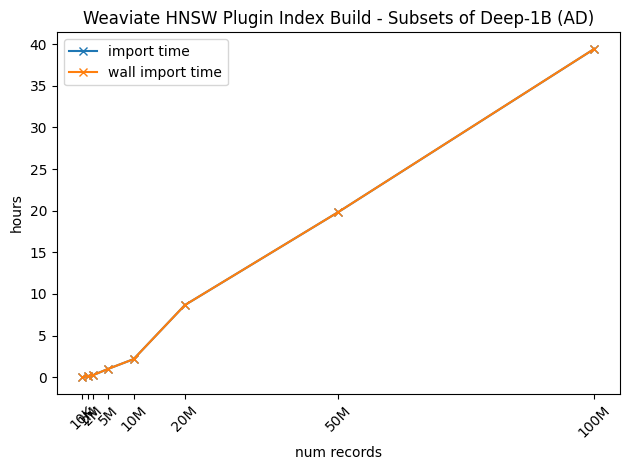

In [10]:
# Plot import/train times

# compute average train time via groupby
avg_import_time = \
    summary_df.groupby( [ 'numrecs' ] ) ['import_time'].mean()

# compute average wall import time via groupby
avg_wall_import_time = \
    summary_df.groupby( [ 'numrecs' ] ) ['wall_time'].mean()

# get the plot points for import time
xs = []
ys = []
for idx in avg_import_time.index:
    x = idx
    xs.append(x)
    y = avg_import_time[idx]/(60.0*60.0)
    ys.append(y)
print("train time", xs,ys)

# get the plot points for wall import time
wxs = []
wys = []
for idx in avg_wall_import_time.index:
    x = idx
    wxs.append(x)
    y = avg_wall_import_time[idx]/(60.0*60.0)
    wys.append(y)
print("wall import time", wxs,wys)

# plot the lines and label the plot
fig, ax = plt.subplots()
ax.plot(xs,ys, marker='x', label="import time")
ax.plot(wxs,wys, marker='x', label="wall import time")
ax.set_ylabel('hours')
ax.set_xlabel('num records')
ax.set_xticks(xs)
ax.set_xticklabels(['10K','1M', '2M', '5M', '10M', '20M', '50M', '100M'], rotation = 45)
ax.set_title("Weaviate HNSW Plugin Index Build - Subsets of Deep-1B (AD)")
ax.legend(loc='best')
fig.tight_layout()
fig.savefig("results/weaviate_hnsw_build_time_ad.png")

# TODO:  plot the variance at each X

[0.9958999999999997, 0.9536999999999969, 0.941999999999997, 0.9327999999999966, 0.9207999999999981, 0.9024999999999971, 0.8801999999999967, 0.870999999999997] [0.12936, 0.587304, 0.691642, 1.347785, 1.569568, 2.0235329999999996, 2.511672, 2.715001]
[0.9992, 0.9799999999999978, 0.973799999999998, 0.9667999999999978, 0.9610999999999971, 0.9531999999999975, 0.9371999999999975, 0.9275999999999972] [0.22597799999999998, 1.375394, 1.709593, 1.687331, 3.0096939999999996, 3.546382, 4.208738, 4.7268229999999996]
[1.0, 0.991799999999999, 0.9875999999999987, 0.9852999999999987, 0.9805999999999984, 0.9785999999999982, 0.966099999999998, 0.9639999999999976] [0.4908899999999999, 1.776278, 2.4136560000000005, 4.475459000000001, 5.1498349999999995, 5.999729, 9.766559, 9.006533000000001]
[1.0, 0.9962999999999996, 0.9945999999999995, 0.9927999999999991, 0.990199999999999, 0.9880999999999989, 0.9819999999999988, 0.9815999999999984] [0.787574, 4.202005, 4.557437, 7.213525, 9.349537999999999, 10.931389, 13

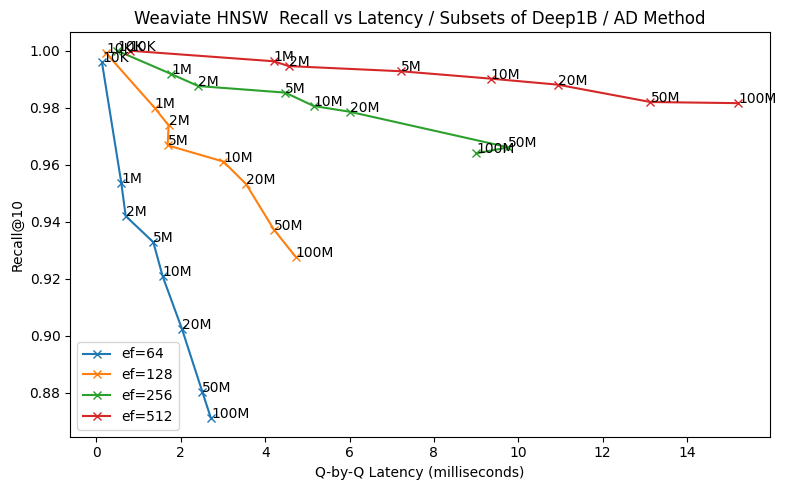

In [11]:
# plot Weaviate recall vs latency

# get unique gem bit sizes
efs = summary_df['ef'].unique()

# prepare one plot
fig, ax = plt.subplots(figsize=(8,5))

# collect data points for the line for each bit size and plot each line
for ef in efs: # we don't need to show 512 and 768

    # TODO:  Needs a CPUs inner loop
    
    # compute mean of average recall_10 grouped by num records
    df_means = \
        summary_df[ summary_df['ef']==ef ]\
            .groupby( [ 'numrecs' ] )\
            .mean(['recall_10','search_mean'])
 
    dset_sizes = [ idx for idx in list(df_means.index) ]
    dset_sizes.sort()
    #print(dset_sizes)

    # get the plot points for recall vs latency
    recalls = [ r for r in list(df_means['recall10_mean']) ]
    latencies = [ l for l in list(df_means['search_mean']) ]
    print(recalls, latencies)

    # plot the line
    ax.plot(latencies,recalls, marker='x', label='ef=%d' % ef)

    # label each point
    for i,j,s in zip(latencies,recalls,dset_sizes):
        off = (0,0)
        ax.annotate(hsize(s),  xy=(i + off[0], j + off[1]))

ax.set_xlabel("Q-by-Q Latency (milliseconds)")
ax.set_ylabel("Recall@10")
ax.set_title("Weaviate HNSW  Recall vs Latency / Subsets of Deep1B / AD Method")
ax.legend(loc='best')
fig.tight_layout()
fig.savefig("results/weaviate_hnsw_recall_vs_latency_ad.png")
